In [1]:
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    LlamaForCausalLM,
    TrainingArguments,
    logging,
    set_seed,
)
from functools import partial
from redditqa.data.smart_filter import question_filter
import datasets as ds

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-13 17:48:06.131340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 17:48:06.131380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 17:48:06.132442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 17:48:06.138412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to 

In [2]:
set_seed(43)

In [3]:
dataset = ds.load_from_disk("/scratch1/redditqa/cached_datasets/AskHistorians_question_filtered.jsonl")
question_filter_func = partial(question_filter, accepted_token_str=["y", "yes"])
dataset = dataset.filter(question_filter_func)
train_valid = dataset.train_test_split(test_size=0.1)["train"]

In [4]:
train_valid["question_title"][:10]

['What are the factors behind of the slow population growth of France in the 19th Century?',
 'Question about what the Germans wanted to achieve in World War 1',
 'Is there any accepted explanation to the existence of the Danzig Massacres?',
 'Was there "collateral racism" against non-Japanese Asians after pearl harbor, similar to the spike in mistaken identity hatecrime after 9-11?',
 'After colonialism/cold war: Is it viable to say that we live in the most peaceful time im human history?',
 'How were war chariots used in Mycenaean Greece? What sources could I refer to in order to further investigate the matter?',
 'Did the samurai ride into battle with armor and what combat would really look like?',
 'Did Eurasian Nomads(Scythians, Sarmatians, etc.) use wagons?',
 'Why do the Dutch (Netherlands) have such an affinity with the color orange?',
 'When and Why did wearing blue jeans become both socially acceptable, as well as popular and fashionable?']

In [5]:
from redditqa.data import pair_generation

pairs = pair_generation.apply(train_valid.select(range(20)))

In [6]:
pairs[0]

{'question_created_utc': 1343645212000,
 'question_retrieved_on': 0,
 'question_deleted': False,
 'question_title': 'What are the factors behind of the slow population growth of France in the 19th Century?',
 'question_selftext': 'Just being curious. Their low population strongly affected plannings and wars (especially WWI and WWII). Other European countries had very quick population growth at the same period, but there seems to be no real advantage (resource-wise) for them to do that.',
 'question_score': 23,
 'question_char_length': 88,
 'question_selftext_char_length': 259,
 'graded_output': [{'probability': 0.9298139810562134,
   'token_id': 5613,
   'token_str': 'Yes'}],
 'response_j': 'This is a very hard question to answer, and one that is not looked at that often for this reason. \n\nI would ascribe the low population growth in 19th century France to cultural factors that privileged celibacy, and to internal demographic shifts represented by large internal migrations, mostly fr

In [7]:
dataset[0]

{'question_created_utc': 1672517730000,
 'question_retrieved_on': 1673167825000,
 'question_deleted': False,
 'question_title': 'Are there any Major or semi- major generally accepted historic events that we only know about due to secondary sources?',
 'question_selftext': "I seem to remember that there were from my history classes but it's been a very long time since those classes, so I'll ask the experts.",
 'question_score': 126,
 'question_char_length': 119,
 'question_selftext_char_length': 135,
 'answers': [{'answer_body': 'In many cases, it can sort-of depend on how you define "primary" vs "secondary." Conventionally a primary source is a document "from the time" under study, but it can be difficult to determine how far that extends, particularly in ancient history. Something written in 400 BCE is monumentally closer to something that happened in 600 BCE than we are now, but being 200 years after the fact, it is also very much a secondary source in that it builds on original "tru

<Axes: >

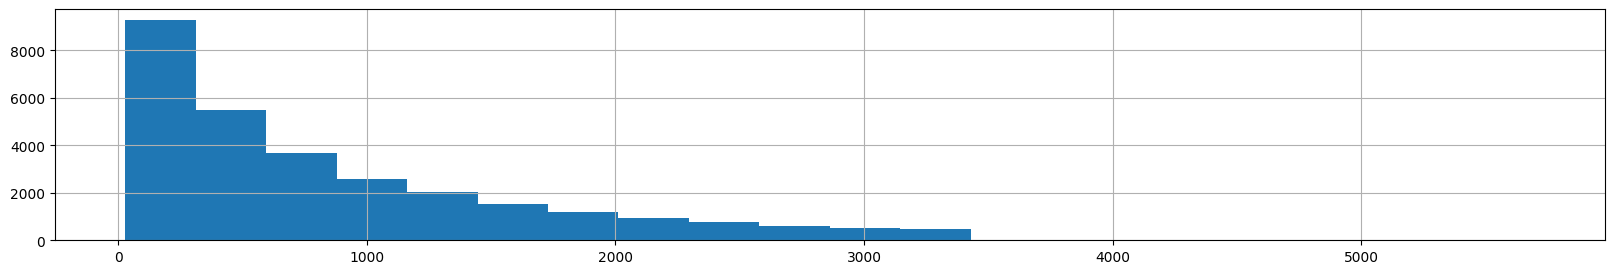

In [10]:
import pandas as pd 

def create_qa(row): 
    return {"qa": f"Question: {row['question_title']}\nAnswer: {row['answers'][0]['answer_body']}"}

pd.Series(
    dataset.map(create_qa, batched=False)["qa"]
).apply(len).apply(lambda x: x/3).hist(bins=20, figsize=(20, 3))